In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data = {self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        return out
        
    def __radd__(self, other):
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
        
    def __rmul__(self, other):
        return self * other
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += out.grad * (1 - t**2)
        out._backward = _backward
        return out

    def __neg__(self):
        return -1 * self
        
    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only accepts int or float"
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            self.grad += out.grad * other * self.data**(other-1)
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()
            

In [26]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = " %s | data %.4f | grad %.4f " % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for (n1, n2) in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

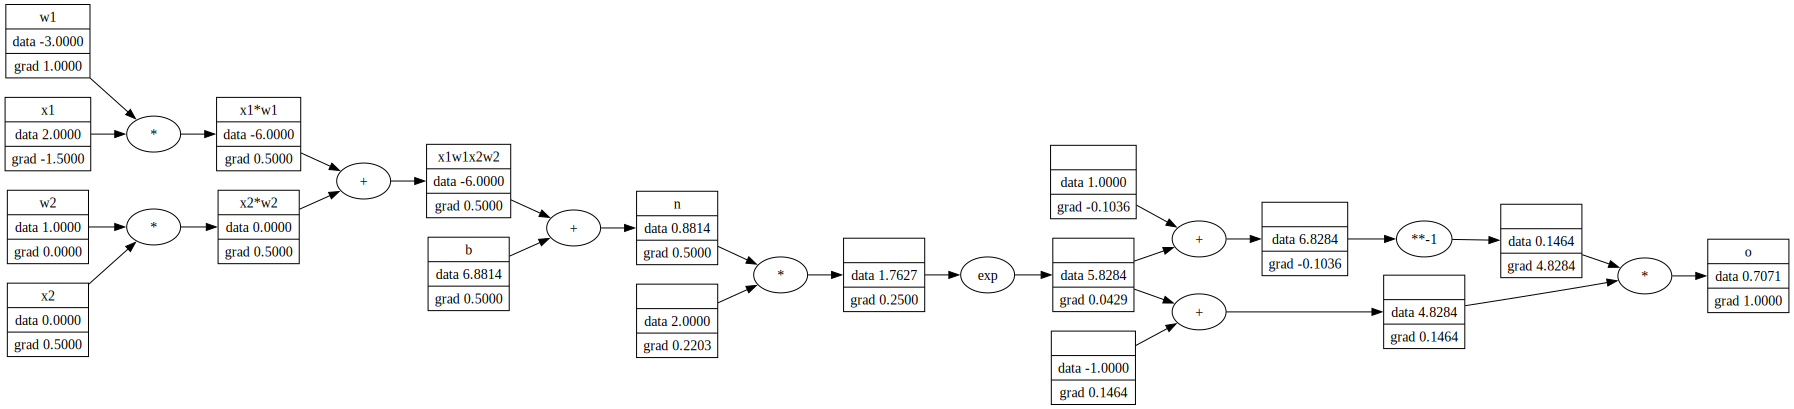

In [27]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2 (synaptic strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
# cell body raw activation without the activation function (tanh)
n = x1w1x2w2 + b; n.label='n'
# --- 
e = (2*n).exp()
o = (e - 1) / (e + 1)
# o = n.tanh(); o.label = 'o' 
# ----
o.label = 'o'
o.backward()

draw_dot(o)

In [31]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()

print("o.data = ", o.data.item())
print("____")
print("x1.grad = ", x1.grad.item())
print("w1.grad = ", w1.grad.item())
print("x2.grad = ", x2.grad.item())
print("w2.grad = ", w2.grad.item())

o.data =  0.7071066904050358
____
x1.grad =  -1.5000003851533106
w1.grad =  1.0000002567688737
x2.grad =  0.5000001283844369
w2.grad =  0.0


In [48]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[Value(data = 0.8856053661860919)]

In [62]:
class Neuron:
    def __init__(self, nin):
        self.ws = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
                       
    def __call__(self, x):
        act = sum((xi*wi for xi, wi in zip(x, self.ws)), self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.043148670432252664)

In [64]:
'''
Binary classifier neural net
xs: different inputs
ys: desired output per input
'''

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data = 0.043148670432252664),
 Value(data = -0.7056253254178705),
 Value(data = -0.46895856244106976),
 Value(data = 0.1644779209947867)]